In [131]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import keras_tuner as kt
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from tensorflow.keras.models import save_model, model_from_json, Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow import keras
from keras_tuner.tuners import RandomSearch
from keras.models import load_model
from plotly.subplots import make_subplots
from keras_tuner.engine.hyperparameters import HyperParameters
import warnings
warnings.simplefilter("ignore", UserWarning)

In [2]:
df = pd.read_csv('../data/cleaned_data.csv')
data = df['close'].values
data = data.reshape(-1,1)
lookback = 50

In [3]:
def min_max_scale(data: np.array) -> np.array:
    """ Tranform the function into min max scale"""
    data = MinMaxScaler().fit_transform(data)
    return data

def training_test_divider(data: np.array, threshold: int):
    """ This functions divideds the data (close price) into 80 20 ration for test and train data """
    train_test_divider = int(len(data)*threshold)
    training_data, testing_data = data[:train_test_divider], data[train_test_divider:]
    return training_data, testing_data

def sliding_window(data: [], window_length: int):
    """ 
    This function creates a sliding window pattern from the data given and window length given.
    For example:
    Data = [1,2,3,4,5,6]
    sliding window = 2
    X = [[1,2],[2,3],[3,4],[4,5]]
    Y = [3,4,5,6]
    
    """
    X = []
    Y = []
    for i in range(len(data) - window_length):
        X.append(data[i: i+ window_length])
        Y.append(data[i+window_length])
    
    return np.array(X), np.array(Y)

In [4]:
train, test = training_test_divider(data, 0.8)
train_normalized = min_max_scale(train)
test_normalized = min_max_scale(test)

In [5]:
x_train, y_train = sliding_window(train_normalized, lookback)
x_test, y_test = sliding_window(test_normalized, lookback)

In [7]:
def model_builder(hp):

    hp_activation = hp.Choice('activationfunc', ['relu', 'tanh', 'selu'])
    hp_dropout = hp.Choice('dropout', values=[0.05, 0.1, 0.2])  
    model = Sequential()
    model.add(LSTM(hp.Int('first_layer_neurons', min_value=10, max_value=25, step=2), 
                   activation= hp_activation, return_sequences=True))
    model.add(Dropout(hp_dropout))
    model.add(LSTM(hp.Int('second_layer_neurons', min_value=10, max_value=25, step=2), activation= hp_activation))
    model.add(Dense(1))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse',
                  metrics='mse')

    return model

In [8]:
tuner = kt.RandomSearch(model_builder,
                     objective='val_mse',
                     max_trials=30,
                     directory='my_dir',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir\intro_to_kt\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\intro_to_kt\tuner0.json


In [9]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
activationfunc (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu'], 'ordered': False}
dropout (Choice)
{'default': 0.05, 'conditions': [], 'values': [0.05, 0.1, 0.2], 'ordered': True}
first_layer_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 25, 'step': 2, 'sampling': None}
second_layer_neurons (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 25, 'step': 2, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [10]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [11]:
tuner.search(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit


In [12]:
# tuner.results_summary()

In [13]:
best_hps = tuner.get_best_hyperparameters()[0]
# Build the model with the best hp.
model = model_builder(best_hps)

In [41]:
print('Best Hyper Parameters\n')
print('Layer 1 neuron:')
print(best_hps.get('first_layer_neurons'))
print('\nLayer 2 neuron:')
print(best_hps.get('second_layer_neurons'))
print('\nActivation Function:')
print(best_hps.get('activationfunc'))
print('\nlearning_rate:')
print(best_hps.get('learning_rate'))
print('\nDropout rate:')
print(best_hps.get('dropout'))

Best Hyper Parameters

Layer 1 neuron:
24

Layer 2 neuron:
24

Activation Function:
selu

learning_rate:
0.001

Dropout rate:
0.2


In [18]:
stop_training_early = keras.callbacks.EarlyStopping(monitor='mse', patience=5)

In [20]:
history = model.fit(x_train, y_train, epochs=50 , verbose=2, shuffle=False, callbacks=[stop_training_early])

Epoch 1/50
1031/1031 - 57s - loss: 1.9937e-04 - mse: 1.9937e-04 - 57s/epoch - 55ms/step
Epoch 2/50
1031/1031 - 56s - loss: 2.4576e-04 - mse: 2.4576e-04 - 56s/epoch - 55ms/step
Epoch 3/50
1031/1031 - 57s - loss: 2.5491e-04 - mse: 2.5491e-04 - 57s/epoch - 56ms/step
Epoch 4/50
1031/1031 - 59s - loss: 2.7199e-04 - mse: 2.7199e-04 - 59s/epoch - 57ms/step
Epoch 5/50
1031/1031 - 59s - loss: 2.7851e-04 - mse: 2.7851e-04 - 59s/epoch - 57ms/step
Epoch 6/50
1031/1031 - 57s - loss: 2.9189e-04 - mse: 2.9189e-04 - 57s/epoch - 55ms/step


In [95]:
# model = load_model('saved_model/my_model')

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 24)            2496      
                                                                 
 dropout_1 (Dropout)         (None, 50, 24)            0         
                                                                 
 lstm_3 (LSTM)               (None, 24)                4704      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 7,225
Trainable params: 7,225
Non-trainable params: 0
_________________________________________________________________


In [19]:
y_predict = model.predict(x_test)

257/257 [==============================] - 3s 9ms/step


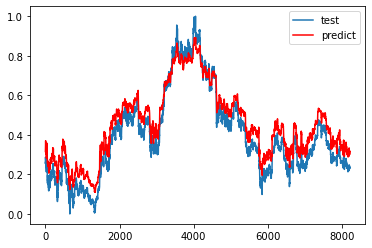

In [20]:
plt.plot(y_test.flatten(), label='test')
plt.plot(y_predict.flatten(), 'r-', label='predict')
plt.legend()

In [21]:
print(f'RMSE: {mean_squared_error(y_test.flatten(), y_predict.flatten(), squared=False)}')

RMSE: 0.07064085393617453


In [33]:
# model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


## WALK OVER VALIDATION

In [120]:
predictions = []
history = train_normalized
for i in tqdm(test_normalized):
    history = history[-lookback:] 
    ## new axis because 3D is expected as input ##
    prediction = model.predict(history[np.newaxis,:,:], verbose = 0)
    predictions.append(float(prediction))
    ## a square bracket to match dimension at individual level ##
    history = np.append(history, [i], axis=0)

100%|██████████████████████████████████████████████████████████████████████████████| 8256/8256 [07:16<00:00, 18.93it/s]


In [126]:
print(f'RMSE: {mean_squared_error(predictions, test_normalized.flatten(), squared=False)}')

RMSE: 0.07088145558495486


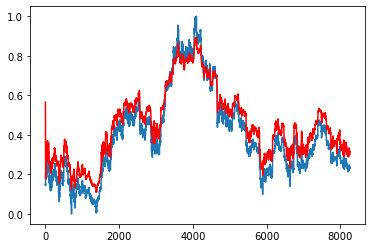

In [128]:
plt.plot(test_normalized.flatten(), label='test')
plt.plot(predictions, 'r-', label='predict')
# plt.legend()

In [99]:
# prediction = []
# data_test = train_normalized[-lookback:]
# # data_test.shape
# # data_test.reshape(1,data_test.shape[0],data_test.shape[1])
# # for i in test_normalized:
# predict = model.predict(data_test.reshape(1,data_test.shape[0],data_test.shape[1]))
# prediction.append(float(predict))
# prediction
# prediction = []
# # for i in test_normalized:
# train_normalized[-lookback:][np.newaxis,:,:]
# a = np.append(train_normalized,[[1.234]], axis=0)
# a

1/1 [==============================] - 0s 27ms/step


[0.5653396844863892]